
# Model Building Jupyter Notebook
This Jupyter Notebook serves as the main file for constructing machine learning models and building appropriate feature sets. The notebook is organized into four key sections:

### 1. Data Pre-Processing
In this section, we will ensure the data is adequately processed for model building. We will:

- Assess the current state of data processing.

- Identify any additional features that need to be added to improve model efficiency.
### 2. Model Building
- Here, we will develop the initial models that will be trained on the data processed in the previous section. This section focuses on:

- Constructing the models without fine-tuning or interpretation at this stage.
### 3. Model Training and Evaluation
In this section, we will:

- Train the models using the prepared data.

- Evaluate the performance of each model.

- Determine if the model outputs are reliable and worth further consideration.
### 4. Results
The final section will involve analyzing the decision-making process of the models. We will:

- Examine the results of linear regression models.

- For more advanced algorithms, delve into both local and global interpretations to understand the decision-making of these "black box" models.


#### Importing the neccessary libraries

In [13]:
import pandas as pd # This is to read csv files
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Classification Evaluation
from sklearn.linear_model import LogisticRegression # Logit Regression

from sklearn.metrics import roc_curve, auc # Model Evaluation ROC
import matplotlib.pyplot as plt # General Plotting

btc = pd.read_csv('data/model/btc_model_price.csv')

##### Preparing the model dataset

In [17]:
# BTC - Only selecting required columns from the main dataset
btc.index = btc.Date
btc = btc[['Price', 'Open', 'High', 'Low', 'Volume',
       'pct_change', 'Tomorrow', 'Gold_Price', 'Gold_Volume', 'Gold_pct_change', 
       'SNP_Price', 'SNP_pct_change', 'VIX_Price', 
       'VIX_pct_change', 'MA_td', '3MA_td',
       '%K_td', '%D_td', 'RSI_td', 'Momentum_td', 'MACD_td', 'CCI_td']]

btc = btc.dropna()

In [21]:
variables = [var for var in btc.columns if var != ['Tomorrow']]  # Adjust this if you only want to create lags for specific variables

btc_1 = btc.copy()
# Adding n lagged variables for each variable in the DataFrame
for var in variables: # value set to twelce as indepdent variable is the last column out of a total 13
    for lag in range(1, 6):
        btc_1[f'{var}_lag{lag}'] = btc[var].shift(lag)

# Optional: Remove rows with NaN values that result from shifting
btc_1.dropna(inplace=True)

btc_1

C:\Users\mulle\AppData\Local\Temp\ipykernel_17520\1157348822.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  btc_1[f'{var}_lag{lag}'] = btc[var].shift(lag)
C:\Users\mulle\AppData\Local\Temp\ipykernel_17520\1157348822.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  btc_1[f'{var}_lag{lag}'] = btc[var].shift(lag)
C:\Users\mulle\AppData\Local\Temp\ipykernel_17520\1157348822.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

,Price,Open,High,Low,Volume,pct_change,Tomorrow,Gold_Price,Gold_Volume,Gold_pct_change,...,MACD_td_lag1,MACD_td_lag2,MACD_td_lag3,MACD_td_lag4,MACD_td_lag5,CCI_td_lag1,CCI_td_lag2,CCI_td_lag3,CCI_td_lag4,CCI_td_lag5
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-30,68354.7,67631.3,69504.7,67138.4,66840.0,0.0106,0,2366.5,188890.0,0.0062,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-05-29,67635.8,68366.2,68897.6,67143.2,52130.0,-0.0107,1,2352.0,2830.0,-0.0065,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-05-28,68366.0,69428.3,69560.7,67299.9,71390.0,-0.0153,0,2367.3,1490.0,0.0046,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-05-24,68547.6,67971.1,69212.0,66685.8,63280.0,0.0084,1,2345.4,690.0,-0.0012,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-23,67975.7,69166.3,70041.0,66578.1,89450.0,-0.0171,1,2348.2,1140.0,-0.0231,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-07,41546.7,43097.9,43127.7,40810.0,88360.0,-0.0360,1,1797.4,238930.0,0.0046,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0
2022-01-06,43097.5,43431.6,43772.3,42481.1,63080.0,-0.0076,0,1789.2,238640.0,-0.0197,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-01-05,43425.9,45833.1,47019.4,42535.1,83740.0,-0.0526,0,1825.1,173340.0,0.0058,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


##### Model 1: Logit Regression

In [24]:
# X and y are the depdendent variables and indepdendent variables respectively
columns = btc_1.drop(columns='Tomorrow').columns.tolist()
X = btc_1[columns]
y = btc_1['Tomorrow']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.576271186440678
Confusion Matrix:
[[55 27]
 [48 47]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        82
           1       0.64      0.49      0.56        95

    accuracy                           0.58       177
   macro avg       0.58      0.58      0.58       177
weighted avg       0.59      0.58      0.57       177



C:\Users\mulle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC Curve to test model evaluation

###### The ROC (Receiver Operating Characteristic) curve is a graphical representation used to evaluate the performance of a classification model. It plots the true positive rate (sensitivity) against the false positive rate (1-specificity) across various threshold settings. The curve illustrates the trade-off between sensitivity and specificity: as one increases, the other may decrease. The area under the curve (AUC) provides a single scalar value to summarize the model's ability to distinguish between the positive and negative classes, with an AUC of 1 indicating perfect classification and an AUC of 0.5 suggesting no better than random chance. Thus, the ROC curve and AUC are valuable tools for assessing and comparing the discriminatory power of different classifiers.

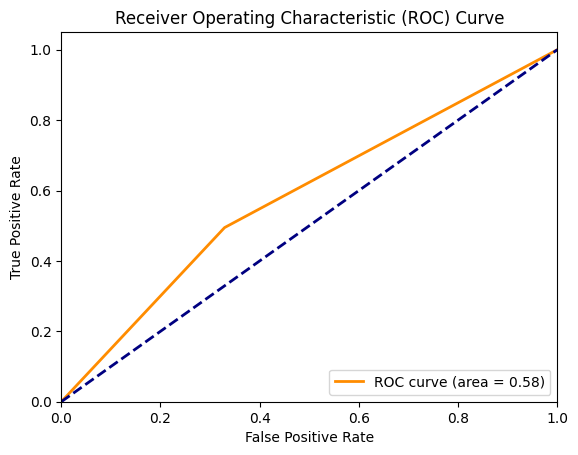

In [25]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()